In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from io import BytesIO
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import torch
import torchvision

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
style_path = r'/content/drive/MyDrive/Colab Notebooks/images/vincent-van-gogh.jpg' # picture with style
img_path = r'/content/drive/MyDrive/Colab Notebooks/images/picture.jpg' # picture of interest to modify

In [3]:
img = Image.open(img_path)
img_style = Image.open(style_path)

In [4]:
shape = np.asarray(img_style).shape
shape

(400, 313, 3)

In [5]:
# delete additional dimensions
if shape[2] == 4:
  img_style = np.asarray(img_style)[:,:,:3]
  img_style = Image.fromarray(img_style)

In [6]:
img = np.asarray(img)
img = np.moveaxis(img, 2, 0)
img = torch.tensor(np.asarray(img))

In [7]:
tr = torchvision.transforms.Resize((shape[0], shape[0]))

In [8]:
img = tr(img)
img.shape

torch.Size([3, 400, 400])

In [9]:
img = img.numpy()

In [10]:
img = np.moveaxis(img, 0, 2)
img.shape

(400, 400, 3)

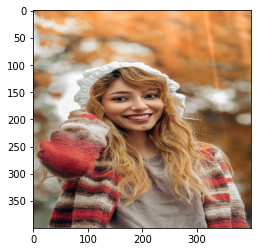

In [11]:
plt.imshow(img)

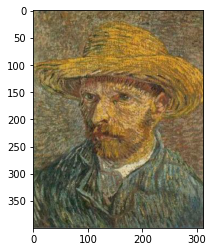

In [12]:
plt.imshow(img_style)

In [13]:
img = Image.fromarray(img)

In [14]:
x_img = keras.applications.vgg19.preprocess_input(np.expand_dims(img, axis=0) )
x_style = keras.applications.vgg19.preprocess_input(np.expand_dims(img_style, axis=0))

In [15]:
x_img.shape, x_style.shape

((1, 400, 400, 3), (1, 400, 313, 3))

In [16]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [17]:
# download VGG19 NN
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False 

In [18]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [19]:
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

In [20]:
print(vgg.input)
for m in model_outputs:
  print(m)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

In [21]:
model = keras.models.Model(vgg.input, model_outputs)
for layer in model.layers:
    layer.trainable = False

print(model.summary()) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [22]:
def get_feature_representations(model):
  # batch compute content and style features
  style_outputs = model(x_style)
  content_outputs = model(x_img)
  
  # Get the style and content feature representations from our model
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [23]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [24]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

In [25]:
def get_style_loss(base_style, gram_target):
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [26]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  style_weight, content_weight = loss_weights
  
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [27]:
num_iterations=300
content_weight=1e3
style_weight=1e-2

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

In [28]:
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

loss_weights = (style_weight, content_weight)

In [29]:
cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

In [30]:
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None

In [31]:
for i in range(num_iterations):
    with tf.GradientTape() as tape: 
       all_loss = compute_loss(**cfg)
    
    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

      # Use the .numpy() method to get the concrete numpy array
      plot_img = deprocess_img(init_image.numpy())
      imgs.append(plot_img)
      if i % 5 == 0:
        print(f'Iteration: {i}, loss: {loss}')

Iteration: 0, loss: 87122368.0
Iteration: 5, loss: 16857200.0
Iteration: 10, loss: 12979164.0
Iteration: 15, loss: 9355135.0
Iteration: 20, loss: 7520701.5
Iteration: 25, loss: 6846348.5
Iteration: 30, loss: 6091106.0
Iteration: 35, loss: 5402350.0
Iteration: 40, loss: 4998489.0
Iteration: 45, loss: 4682572.0
Iteration: 50, loss: 4494514.0
Iteration: 55, loss: 4288389.0
Iteration: 60, loss: 4043116.0
Iteration: 65, loss: 3836273.0
Iteration: 70, loss: 3640764.25
Iteration: 75, loss: 3516713.0
Iteration: 80, loss: 3379557.5
Iteration: 85, loss: 3238350.25
Iteration: 90, loss: 3110832.0
Iteration: 95, loss: 2976263.0
Iteration: 100, loss: 2857605.25
Iteration: 105, loss: 2768060.25
Iteration: 110, loss: 2666069.5
Iteration: 115, loss: 2569729.0
Iteration: 120, loss: 2489502.5
Iteration: 125, loss: 2403283.75
Iteration: 130, loss: 2333991.0
Iteration: 135, loss: 2264393.75
Iteration: 140, loss: 2194663.75
Iteration: 145, loss: 2135422.25
Iteration: 150, loss: 2078216.75
Iteration: 155, lo

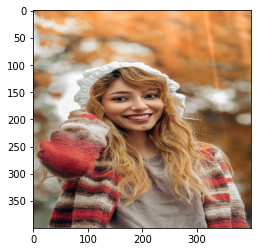

In [32]:
plt.imshow(img)

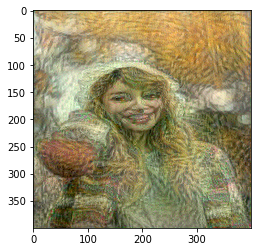

In [33]:
plt.imshow(best_img)

In [34]:
print(best_loss)

tf.Tensor(1125450.4, shape=(), dtype=float32)
